In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [2]:
# load dataset
df = pd.read_csv('fraud.csv')
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# count of fraud and non-fraud cases
fraud_df = df[df['isFraud'] == 1]
non_fraud_df = df[df['isFraud'] == 0]
print('Number of fraud cases: ', len(fraud_df))
print('Number of non-fraud cases: ', len(non_fraud_df))

Number of fraud cases:  8213
Number of non-fraud cases:  6354407


In [4]:
# correct for oversampling of non-fraud cases
non_fraud_df = non_fraud_df.sample(n=len(fraud_df)*4)   # 4 times the number of fraud cases
df = pd.concat([fraud_df, non_fraud_df], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)   # shuffle
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,206,CASH_OUT,93113.58,C1566766445,4082.00,0.0,C1383432949,0.00,226108.50,0,0
1,51,CASH_OUT,361460.79,C136533160,361460.79,0.0,C178151720,991487.78,1352948.57,1,0
2,140,TRANSFER,1264895.53,C1039465841,10020.00,0.0,C1863794824,487386.32,1752281.85,0,0
3,135,CASH_OUT,175924.61,C573898065,0.00,0.0,C205300866,436488.94,612413.54,0,0
4,328,TRANSFER,975389.94,C891486597,975389.94,0.0,C951633995,0.00,0.00,1,0


In [5]:
print('Number of fraud cases: ', len(fraud_df))
print('Number of non-fraud cases: ', len(non_fraud_df))

Number of fraud cases:  8213
Number of non-fraud cases:  32852


In [6]:
# check for missing values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
# use label encoding for type, nameOrig, nameDest
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])
df['nameOrig'] = le.fit_transform(df['nameOrig'])
df['nameDest'] = le.fit_transform(df['nameDest'])
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,206,1,93113.58,12063,4082.00,0.0,5733,0.00,226108.50,0,0
1,51,1,361460.79,7782,361460.79,0.0,11668,991487.78,1352948.57,1,0
2,140,4,1264895.53,849,10020.00,0.0,12953,487386.32,1752281.85,0,0
3,135,1,175924.61,32016,0.00,0.0,15718,436488.94,612413.54,0,0
4,328,4,975389.94,38700,975389.94,0.0,28190,0.00,0.00,1,0


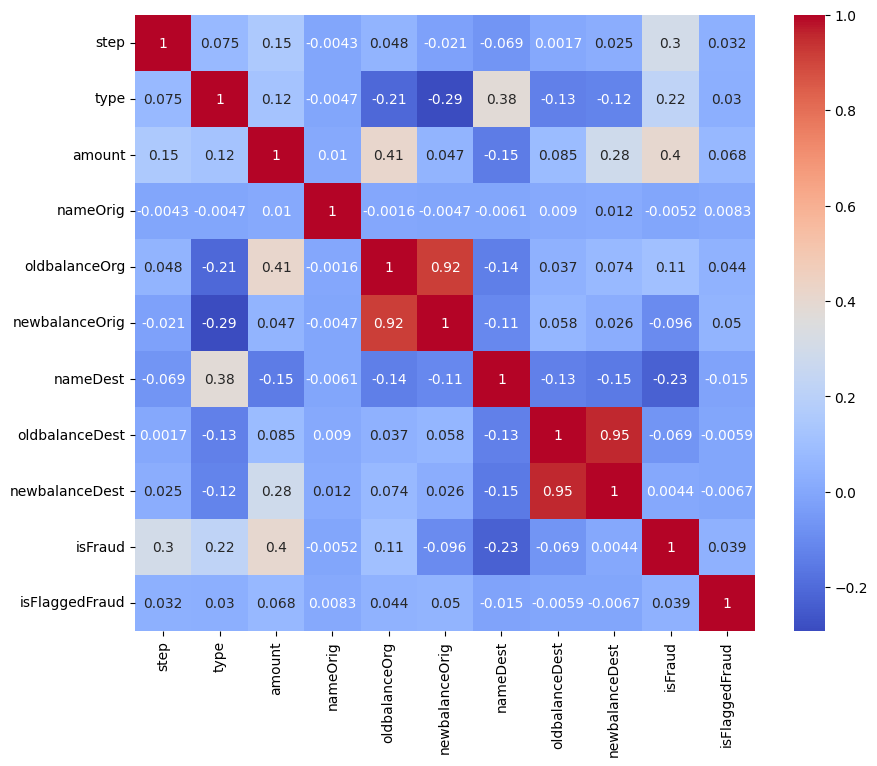

In [8]:
# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [9]:
# split into train and test sets
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# scale the data for all but isFraud
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [11]:
# train logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
lr_y_pred = log_reg.predict(X_test)
print('Accuracy score: ', accuracy_score(y_test, lr_y_pred))

Accuracy score:  0.9393644222573968


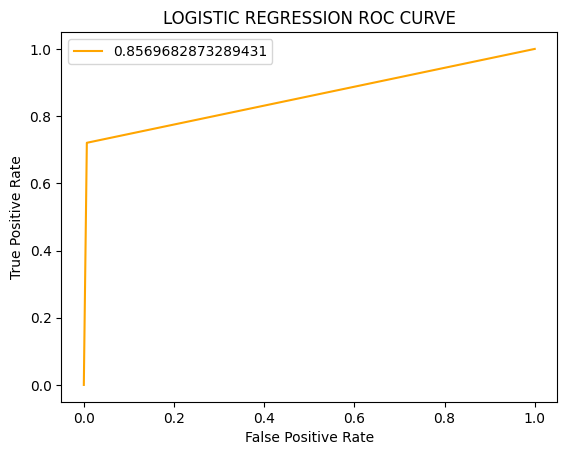

In [12]:
# ROC curve
lr_auc = roc_auc_score(y_test, lr_y_pred)
fpr, tpr, _ = roc_curve(y_test, lr_y_pred)
plt.plot(fpr, tpr, color = 'orange', label = lr_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LOGISTIC REGRESSION ROC CURVE')
plt.legend()
plt.show()


In [13]:
# train random forest model
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)


RandomForestClassifier()

In [14]:
# evaluate model
rf_y_pred = random_forest.predict(X_test)
print(confusion_matrix(y_test, rf_y_pred))
print(classification_report(y_test, rf_y_pred))
print('Accuracy: ', accuracy_score(y_test, rf_y_pred))

[[6549   39]
 [  26 1599]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6588
           1       0.98      0.98      0.98      1625

    accuracy                           0.99      8213
   macro avg       0.99      0.99      0.99      8213
weighted avg       0.99      0.99      0.99      8213

Accuracy:  0.9920857177645197


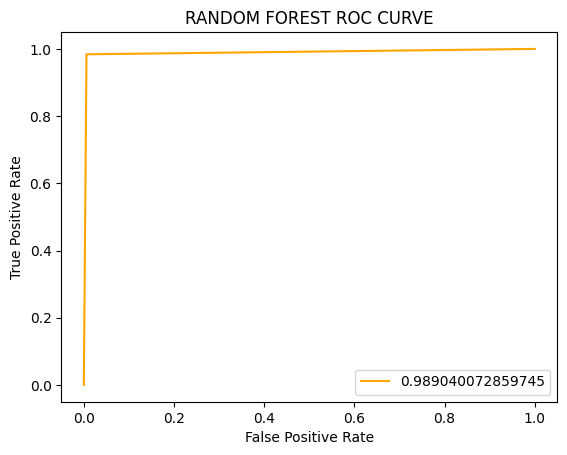

In [15]:
auc = roc_auc_score(y_test, rf_y_pred)
fpr, tpr, _ = roc_curve(y_test, rf_y_pred)
plt.plot(fpr, tpr, color = 'orange', label = auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RANDOM FOREST ROC CURVE')
plt.legend()
plt.show()

In [16]:
# train naive bayes model
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_y_pred = nb.predict(X_test)
print('Accuracy score: ', accuracy_score(y_test, nb_y_pred))

Accuracy score:  0.8267380981370998


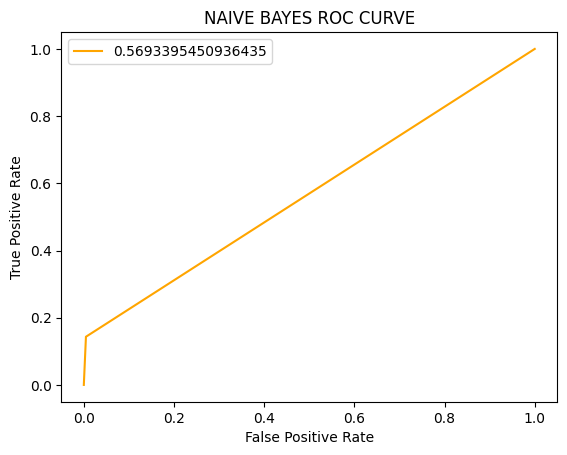

In [17]:
# ROC curve
nb_auc = roc_auc_score(y_test, nb_y_pred)
fpr, tpr, _ = roc_curve(y_test, nb_y_pred)
plt.plot(fpr, tpr, color = 'orange', label = nb_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('NAIVE BAYES ROC CURVE')
plt.legend()
plt.show()

In [18]:
# train knn model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)
print('Accuracy score: ', accuracy_score(y_test, knn_y_pred))

Accuracy score:  0.9325459637160599


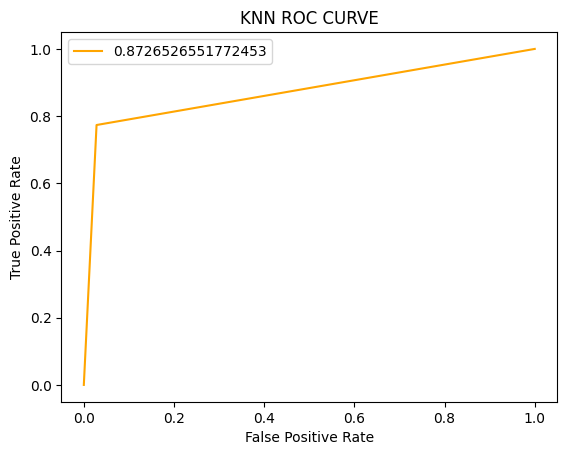

In [19]:
# ROC curve
knn_auc = roc_auc_score(y_test, knn_y_pred)
fpr, tpr, _ = roc_curve(y_test, knn_y_pred)
plt.plot(fpr, tpr, color = 'orange', label = knn_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC CURVE')
plt.legend()
plt.show()

In [22]:
# train svm model
svm = SVC()
svm.fit(X_train, y_train)
svm_y_pred = svm.predict(X_test)
print('Accuracy score: ', accuracy_score(y_test, svm_y_pred))

Accuracy score:  0.9478874954340679


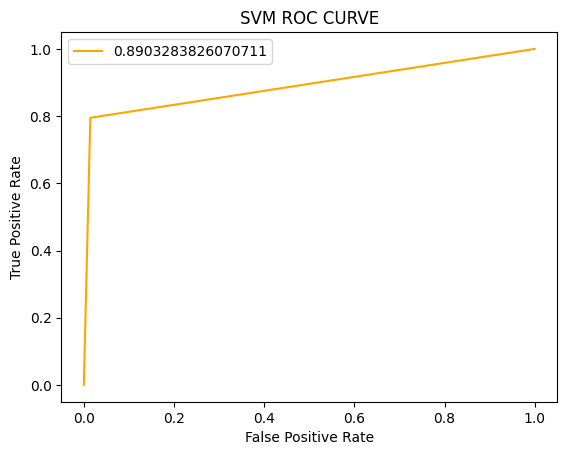

In [23]:
# ROC curve
svm_auc = roc_auc_score(y_test, svm_y_pred)
fpr, tpr, _ = roc_curve(y_test, svm_y_pred)
plt.plot(fpr, tpr, color = 'orange', label = svm_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC CURVE')
plt.legend()
plt.show()

In [25]:
# stacking classifier
estimators = [('rf', random_forest), ('nb', nb), ('knn', knn), ('svm', svm)]
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stack.fit(X_train, y_train)
stack_y_pred = stack.predict(X_test)
print('Accuracy score: ', accuracy_score(y_test, stack_y_pred))

Accuracy score:  0.9922074759527578


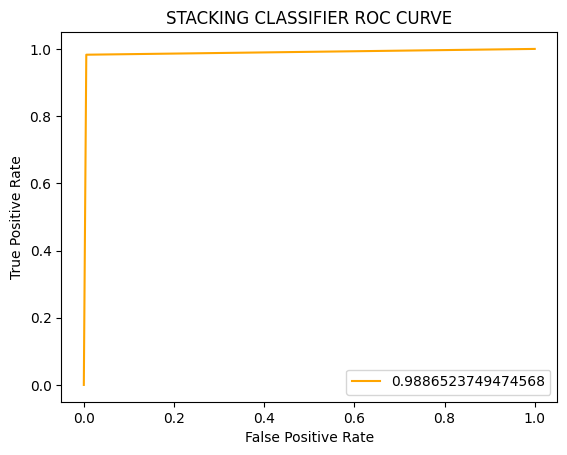

In [26]:
# ROC curve
stack_auc = roc_auc_score(y_test, stack_y_pred)
fpr, tpr, _ = roc_curve(y_test, stack_y_pred)
plt.plot(fpr, tpr, color = 'orange', label = stack_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('STACKING CLASSIFIER ROC CURVE')
plt.legend()
plt.show()

In [27]:
# stacking classifier
estimators_no_rf = [('nb', nb), ('knn', knn), ('svm', svm)]
stack_no_rf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stack_no_rf.fit(X_train, y_train)
stack_no_rf_y_pred = stack.predict(X_test)
print('Accuracy score: ', accuracy_score(y_test, stack_no_rf_y_pred))

Accuracy score:  0.9922074759527578


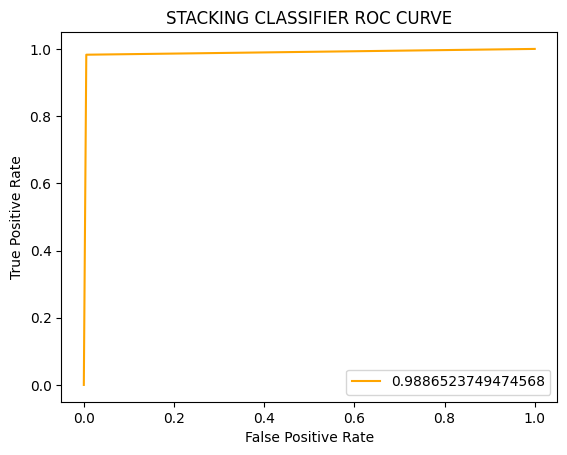

In [28]:
# ROC curve
stack_no_rf_auc = roc_auc_score(y_test, stack_no_rf_y_pred)
fpr, tpr, _ = roc_curve(y_test, stack_no_rf_y_pred)
plt.plot(fpr, tpr, color = 'orange', label = stack_no_rf_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('STACKING CLASSIFIER ROC CURVE')
plt.legend()
plt.show()